Get the data from the google drive. You need to update this based on where your data is in the google drive

In [2]:
import os
DATA_DRIVE = 'data'
DRIVE_PATH = os.path.join('/storage/ice1/6/1/ssubedi33', DATA_DRIVE)
print(os.listdir(DRIVE_PATH))

['.idea', 'LICENSE.txt', 'img', 'test.jsonl', 'README.md', 'dev.jsonl', '.DS_Store', 'train.jsonl']


Import torch and reload external modules

In [3]:
# Just run this block. Please do not modify the following code.
import pandas as pd
import torch

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Now lets check your GPU availability and load some sanity checkers. By default you should be using your gpu for this assignment if you have one available.

In [4]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


Load data here. train.jsonl and dev.jsonl file contains id, image location, label and caption in the image.

In [5]:
path = DRIVE_PATH + '/train.jsonl'
data=pd.read_json(path,lines=True)
print(f"Train set size: {len(data)}")

Train set size: 8500


In [6]:
path = DRIVE_PATH + '/dev.jsonl'
test_data=pd.read_json(path,lines=True)
print(f"Test set size: {len(test_data)}")

Test set size: 500


Split train data in to train, validation set. dev data will be test set.

In [7]:
from sklearn.model_selection import train_test_split

# First split off test set (20%)
train_data, val_data = train_test_split(data, test_size=0.058823, random_state=42)


print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")
print(test_data.head())


Train set size: 8000
Validation set size: 500
Test set size: 500
      id            img  label  \
0   8291  img/08291.png      1   
1  46971  img/46971.png      1   
2   3745  img/03745.png      1   
3  83745  img/83745.png      1   
4  80243  img/80243.png      1   

                                                text  
0              white people is this a shooting range  
1                              bravery at its finest  
2  your order comes to $37.50 and your white priv...  
3  it is time.. to send these parasites back to t...  
4                             mississippi wind chime  


Fine Tuning CLIP model.
This part of the code imports the pretrained model and processor from openAI.
model contains weights and actual architecture.
processor contains tokenizer for words and feature extractor for image. These are used to convert image and caption into numbers that computer will understand.


In [8]:
from transformers import CLIPModel, CLIPProcessor

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


This is a class to tokenize dataset. It takes an input and output tokens for text and image. It uses the same tokenizer that CLIP uses.

In [9]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class MemeDataset(Dataset):
    def __init__(self, dataframe, processor, image_root_dir, max_length = 70):
        self.df = dataframe.reset_index(drop=True)
        self.processor = processor
        #directory where all images are
        self.image_root = image_root_dir
        #to make sure all captions are of same length
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #get the data at idx
        row = self.df.loc[idx]
        #extract path to image
        img_path = f"{self.image_root}/{row['img'].split('/')[-1]}"
        #load image in RGB
        image = Image.open(img_path).convert("RGB")
        #load text
        text = row['text']
        #load label
        label = torch.tensor(row['label'], dtype=torch.float)

        # Convert text and image to tokens
        inputs = self.processor(
            text=text,
            images=image,
            return_tensors="pt",
            padding='max_length',
            max_length=self.max_length,
            truncation=True)

        # Remove batch dimension (1) from processor outputs
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        #add label
        inputs["labels"] = label
        return inputs


Implement MemeDataset class to the train data, validation data, and test data.

In [10]:
from torch.utils.data import DataLoader
import torch

BATCH_SIZE = 32
train_dataset = MemeDataset(train_data, processor, image_root_dir = DRIVE_PATH + "/img")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = MemeDataset(val_data, processor, image_root_dir = DRIVE_PATH + "/img")
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = MemeDataset(test_data, processor, image_root_dir = DRIVE_PATH + "/img")
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Binary classification head at the end of CLIP model. It uses CLIP embeddings from both text and image inputs, and combines them to make a prediction.


In [28]:
import torch.nn as nn

class CLIPBinaryClassifier(nn.Module):
    def __init__(self, clip_model, dropout_prob):
        super().__init__()
        #parent model - pretrained openAI CLIP model
        self.clip = clip_model
        #get image and text embeddings
        dim = self.clip.config.projection_dim
        #Linear classification head with two outputs - Hateful or Not Hateful
        self.classifier = nn.Sequential(
            nn.Linear(dim * 2, dim * 4),
            nn.GELU(),
            nn.Dropout(dropout_prob),
            nn.LayerNorm(dim * 4),
            nn.Linear(dim * 4, dim * 2),
            nn.GELU(),
            nn.Dropout(dropout_prob),
            nn.LayerNorm(dim*2),
            nn.GELU(),
            nn.Linear(dim * 2, 2))
        #self.classifier = nn.Sequential(nn.Linear(dim*2, 2))
        
        self._init_weights()
    #Initialize weights 
    def _init_weights(self):
        for module in self.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, input_ids, attention_mask, pixel_values):
        #forward pass on tokenized inputs, outputs image and text embeddings
        outputs = self.clip(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
        combined = torch.cat([outputs.image_embeds, outputs.text_embeds], dim=1)
        logits = self.classifier(combined)
        return logits

Training Loop

Epoch 1 - Train Loss: 0.6504 | Val Loss: 0.4907
Epoch 2 - Train Loss: 0.5600 | Val Loss: 0.4806
Epoch 3 - Train Loss: 0.5366 | Val Loss: 0.4723
Epoch 4 - Train Loss: 0.5162 | Val Loss: 0.4643
Epoch 5 - Train Loss: 0.4961 | Val Loss: 0.4723
Epoch 6 - Train Loss: 0.4819 | Val Loss: 0.4740
Epoch 7 - Train Loss: 0.4676 | Val Loss: 0.4795
Epoch 8 - Train Loss: 0.4492 | Val Loss: 0.4898
Epoch 9 - Train Loss: 0.4286 | Val Loss: 0.4957
Epoch 10 - Train Loss: 0.4089 | Val Loss: 0.4962
Epoch 11 - Train Loss: 0.3835 | Val Loss: 0.5489
Epoch 12 - Train Loss: 0.3606 | Val Loss: 0.6032
Epoch 13 - Train Loss: 0.3375 | Val Loss: 0.6580
Epoch 14 - Train Loss: 0.3100 | Val Loss: 0.6761
Epoch 15 - Train Loss: 0.2930 | Val Loss: 0.7452
Epoch 16 - Train Loss: 0.2667 | Val Loss: 0.8637
Epoch 17 - Train Loss: 0.2495 | Val Loss: 0.8365
Epoch 18 - Train Loss: 0.2377 | Val Loss: 0.9666
Epoch 19 - Train Loss: 0.2119 | Val Loss: 1.0891
Epoch 20 - Train Loss: 0.1906 | Val Loss: 1.0971
Epoch 21 - Train Loss: 0.1791

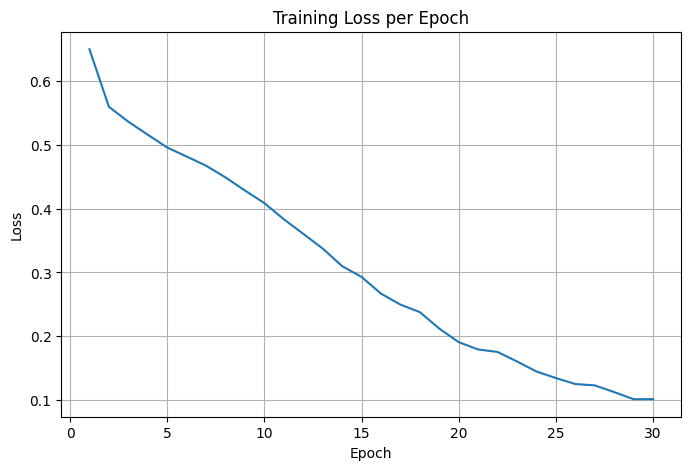

In [32]:
import torch
import matplotlib.pyplot as plt

#move the classifier to cuda
classifier = CLIPBinaryClassifier(model, 0.5).to(device)
#Freeze all parameters of the CLIP backbone
#for param in classifier.clip.parameters():
    #param.requires_grad = False
#opitimzer with learning rate as hyperparameter
learning_rate = 0.0001
optimizer = torch.optim.AdamW(classifier.classifier.parameters(), lr=learning_rate)
#cross entropy loss
criterion = nn.CrossEntropyLoss()
epochs = 30

#Train and validation loss
train_losses = []
val_losses = []

# Training and validation
for epoch in range(epochs):
    classifier.train()
    total_train_loss = 0
    for batch in train_loader:
        # Move inputs and labels to the correct device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device).long()

        # Forward and backward pass
        optimizer.zero_grad()
        outputs = classifier(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    classifier.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device).long()

            outputs = classifier(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), train_losses)
#plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
#plt.legend()
plt.grid(True)
plt.show()

Accuracy

In [33]:
from sklearn.metrics import accuracy_score
import torch

# Set model to evaluation mode
classifier.eval()

# Load all test data at once
with torch.no_grad():
    # Combine all batches into single tensors
    all_input_ids = torch.cat([batch["input_ids"] for batch in test_loader]).to(device)
    all_attention_masks = torch.cat([batch["attention_mask"] for batch in test_loader]).to(device)
    all_pixel_values = torch.cat([batch["pixel_values"] for batch in test_loader]).to(device)
    all_labels = torch.cat([batch["labels"] for batch in test_loader]).to(device)

    # Single forward pass for all test data
    outputs = classifier(
        input_ids=all_input_ids,
        attention_mask=all_attention_masks,
        pixel_values=all_pixel_values
    )

    # Get predictions (using softmax for 0/1 classification)
    probabilities = torch.softmax(outputs, dim=1)
    preds = torch.argmax(probabilities, dim=1).cpu().numpy()
    trues = all_labels.cpu().numpy()

# Calculate accuracy
accuracy = accuracy_score(trues, preds)
print(f"Test Accuracy (full dataset): {accuracy:.4f}")


Test Accuracy (full dataset): 0.6100


AUC-ROC Score: 0.6100


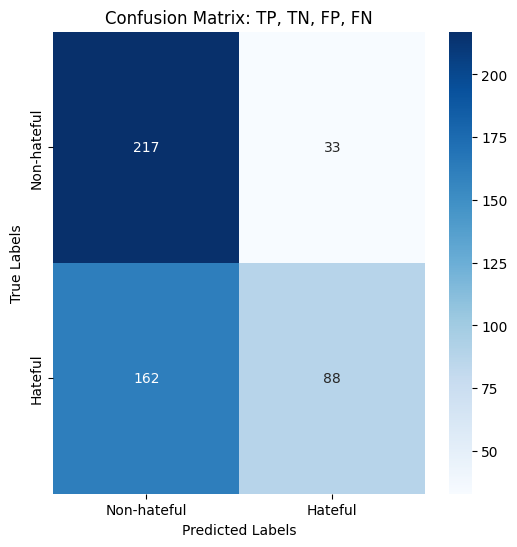

In [34]:
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

auc = roc_auc_score(trues, preds)
print(f"AUC-ROC Score: {auc:.4f}")

cm = confusion_matrix(trues, preds)
tn, fp, fn, tp = cm.ravel()
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-hateful', 'Hateful'],
            yticklabels=['Non-hateful', 'Hateful'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: TP, TN, FP, FN')
plt.show()
